# Multi-Class Classification with Machine Learning
In this notebook, we will explore various machine learning models to solve a multi-class classification problem. We will evaluate and compare the performance of different algorithms on the dataset.


## 1. Imports

In [1]:
import ast
import random
from collections import Counter
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
from IPython.core.display import Image
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from wordcloud import WordCloud
from xgboost import XGBClassifier

from preprocess_functions import build_tree, extract_keys, preprocess_texts, map_targets, merge_all_trees_with_counts, \
    add_edges
from utils import CalibratedLabelRankClassifier, ChainOfClassifiers, LabelPowersetClassifier, \
    assess_models, prune_and_subsample, ConditionalDependencyNetwork, MetaBinaryRelevance

## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = False
RETRAIN = False
RANDOM_STATE = 42
MODEL_LEVEL = 'general'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    'computer security': 'computer security',
    'operating systems': 'operating systems',
    'software': 'software',
    'programming languages': 'software',
    'hardware': 'hardware',
    'electronic components': 'hardware',
    'networking': 'networking',
    'internet technology': 'networking'
}

### Base Models

In [6]:
BASE_CLASSIFIERS = {
    'logistic_regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced'),
    'gaussian_nb': GaussianNB(),
    'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'xgb': XGBClassifier(random_state=RANDOM_STATE)
}

### Directory Paths

In [7]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [8]:
BINARY_PROBLEMS_DIR = MODELS_DIR / 'binary_problems'
ENSEMBLES_DIR = MODELS_DIR / 'ensembles'
MULTICLASS_PROBLEMS_DIR = MODELS_DIR / 'multiclass_problems'
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'

GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'
THREAT_TWEETS_CSV = DATASET_DIR / 'tweets_final.csv'

BR_PKL = BINARY_PROBLEMS_DIR / f'br_{MODEL_LEVEL}.pkl'
CLR_PKL = BINARY_PROBLEMS_DIR / f'clr_{MODEL_LEVEL}.pkl'
CC_PKL = BINARY_PROBLEMS_DIR / f'cc_{MODEL_LEVEL}.pkl'
LP_PKL = MULTICLASS_PROBLEMS_DIR / f'lp_{MODEL_LEVEL}.pkl'
PST_PKL = MULTICLASS_PROBLEMS_DIR / f'pst_{MODEL_LEVEL}.pkl'
CDN_PKL = ENSEMBLES_DIR / f'pkl_{MODEL_LEVEL}.pkl'
MBR_PKL = ENSEMBLES_DIR / f'mbr_{MODEL_LEVEL}.pkl'

### Loading Models

In [9]:
br = joblib.load(filename=BR_PKL) if BR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
clr = joblib.load(filename=CLR_PKL) if CLR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cc = joblib.load(filename=CC_PKL) if CC_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
lp = joblib.load(filename=LP_PKL) if LP_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
pst = joblib.load(filename=PST_PKL) if PST_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cdn = joblib.load(filename=CDN_PKL) if CDN_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
mbr = joblib.load(filename=MBR_PKL) if MBR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest are:
1. computer security/network security
2. computer security/antivirus and malware
3. operating systems/mac os
4. operating systems/windows
5. operating systems/unix
6. operating systems/linux
7. software
8. programming languages, included in software
9. software/databases
10. hardware
11. electronic components, included in hardware
12. hardware/computer/servers
13. hardware/computer/portable computer
14. hardware/computer/desktop computer
15. hardware/computer components
16. hardware/computer networking/router
17. hardware/computer networking/wireless technology
18. networking
19. internet technology, included in networking

In [10]:
threat_tweets = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    .query(expr='relevant == True')
    .drop(labels=[
        'relevant', '_id', 'date',
        'id', 'tweet', 'type',
        'annotation', 'urls', 'destination_url',
        'valid_certificate'
    ], axis=1)
    .dropna(subset=['text'], ignore_index=True)
)

threat_tweets.head()

,text,watson,watson_list,target
0,Protect your customers access Prestashop Ant...,{'technology and computing': {'internet techno...,"[technology and computing, internet technology...","[networking, software, computer security]"
1,Data leak from Huazhu Hotels may affect 130 mi...,"{'travel': {'hotels': {}}, 'home and garden': ...","[travel, hotels, home and garden, home improve...",[other]
2,Instagram App 41.1788.50991.0 #Denial Of #Serv...,{'science': {'weather': {'meteorological disas...,"[science, weather, meteorological disaster, hu...",[hardware]
3,(good slides): \n\nThe Advanced Exploitation o...,{'business and industrial': {'business operati...,"[business and industrial, business operations,...",[operating systems]
4,CVE-2018-1000532 (beep)\nhttps://t.co/CaKbo38U...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...","[software, computer security, hardware]"


Preprocess the `text` column into embeddings

In [11]:
X = preprocess_texts(
    list_str=threat_tweets['text'],
    model_path=GLOVE_6B_300D_TXT,
    embedding_dim=300
)

Convert the `target` column into a binary multi-label matrix

In [12]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=threat_tweets['target'])

Create a dictionary that maps label indices to unique label sets

In [13]:
unique_label_sets, y_lp = np.unique(ar=y, axis=0, return_inverse=True)
label_map_lp = {i: tuple(lbl_set) for i, lbl_set in enumerate(unique_label_sets)}

## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [14]:
all_words = ' '.join(threat_tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('the', 2721), ('a', 2419), ('in', 2342), ('to', 2289), ('of', 2155), ('-', 2048), ('and', 1687), ('vulnerability', 1563), ('Vulnerability', 1417), ('is', 1094)]


#### 4.1.2. Word Cloud

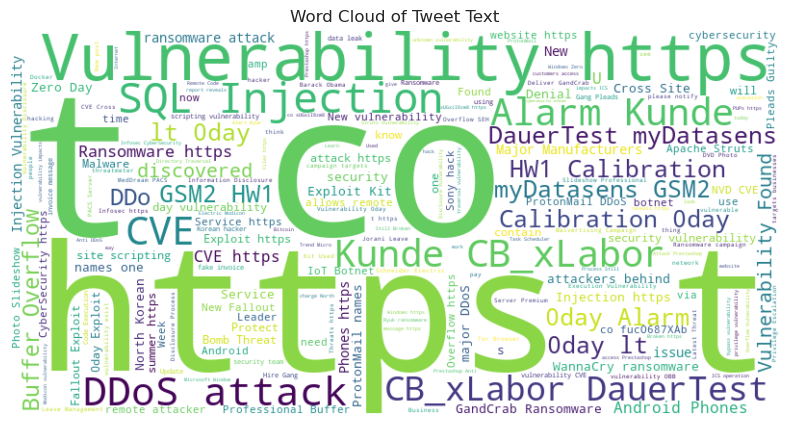

In [15]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(threat_tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

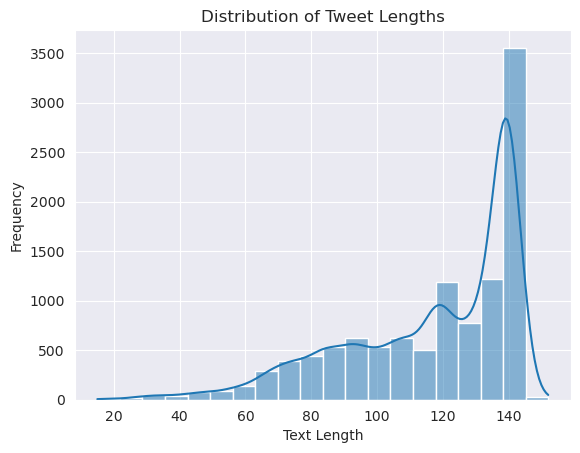

In [16]:
threat_tweets['text_length'] = threat_tweets['text'].apply(func=len)
sns.histplot(
    data=threat_tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.2. Watson Analysis

In [17]:
general_tree, visit_count = merge_all_trees_with_counts(threat_tweets['watson'])

for root, children in general_tree['technology and computing'].items():
    G = pydot.Dot(graph_type="digraph")
    node = pydot.Node(root, style='filled')
    G.add_node(node)
    add_edges(
        graph=G,
        parent=root,
        children=children
    )
    Image(G.create_jpeg())
    G.write_jpeg(f"img/{root}.jpeg")

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [18]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in threat_tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 10061), ('computer security', 5817), ('antivirus and malware', 4269), ('software', 3689), ('hardware', 2156), ('network security', 2113), ('society', 2030), ('computer', 1693), ('crime', 1595), ('business and industrial', 1551)]


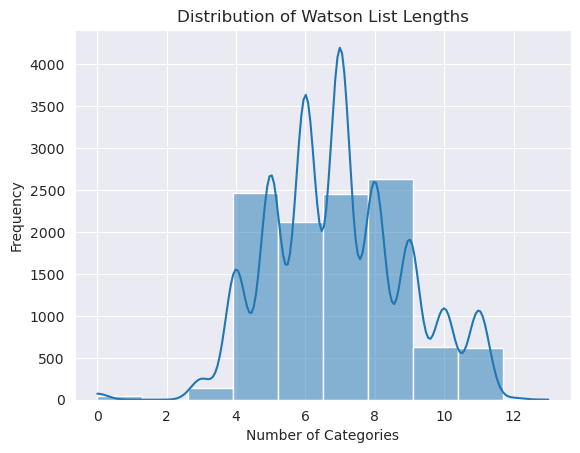

In [19]:
# Category Depth Analysis
threat_tweets['watson_list_length'] = threat_tweets['watson_list'].apply(func=len)

sns.histplot(
    data=threat_tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [20]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in threat_tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'computer security'), 5817), (('technology and computing', 'antivirus and malware'), 4269), (('computer security', 'antivirus and malware'), 4269), (('technology and computing', 'software'), 3689), (('technology and computing', 'hardware'), 2156), (('technology and computing', 'network security'), 2113), (('computer security', 'network security'), 2113), (('technology and computing', 'computer'), 1693), (('hardware', 'computer'), 1693), (('society', 'crime'), 1595)]


In [21]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('technology', 10061), ('computer', 8548), ('antivirus', 4269), ('software', 3692), ('network', 2197), ('hardware', 2156), ('society', 2030), ('business', 1749), ('crime', 1595), ('databases', 1502), ('consumer', 1396), ('law,', 1283), ('science', 1147), ('operating', 1066), ('art', 1064), ('home', 993), ('programming', 924), ('personal', 918), ('property', 851), ('health', 785), ('hobbies', 560), ('tv', 558), ('javascript', 536), ('networking', 507), ('government', 499), ('physics', 488), ('linux', 486), ('optics', 471), ('telephones', 470), ('burglary', 467), ('mobile', 462), ('movies', 457), ('vpn', 444), ('internet', 440), ('assault', 438), ('smart', 430), ('finance', 415), ('legal', 385), ('sports', 351), ('food', 333), ('law', 327), ('disease', 309), ('java', 302), ('travel', 300), ('windows', 300), ('company', 292), ('kidnapping', 290), ('police', 277), ('legislation', 274), ('router', 270), ('disorders', 265), ('weather', 243), ('mental', 237), 

### 4.4. Target Analysis

Target Frequencies:
computer security: 3338
software: 2952
other: 2255
operating systems: 1066
networking: 890
hardware: 611


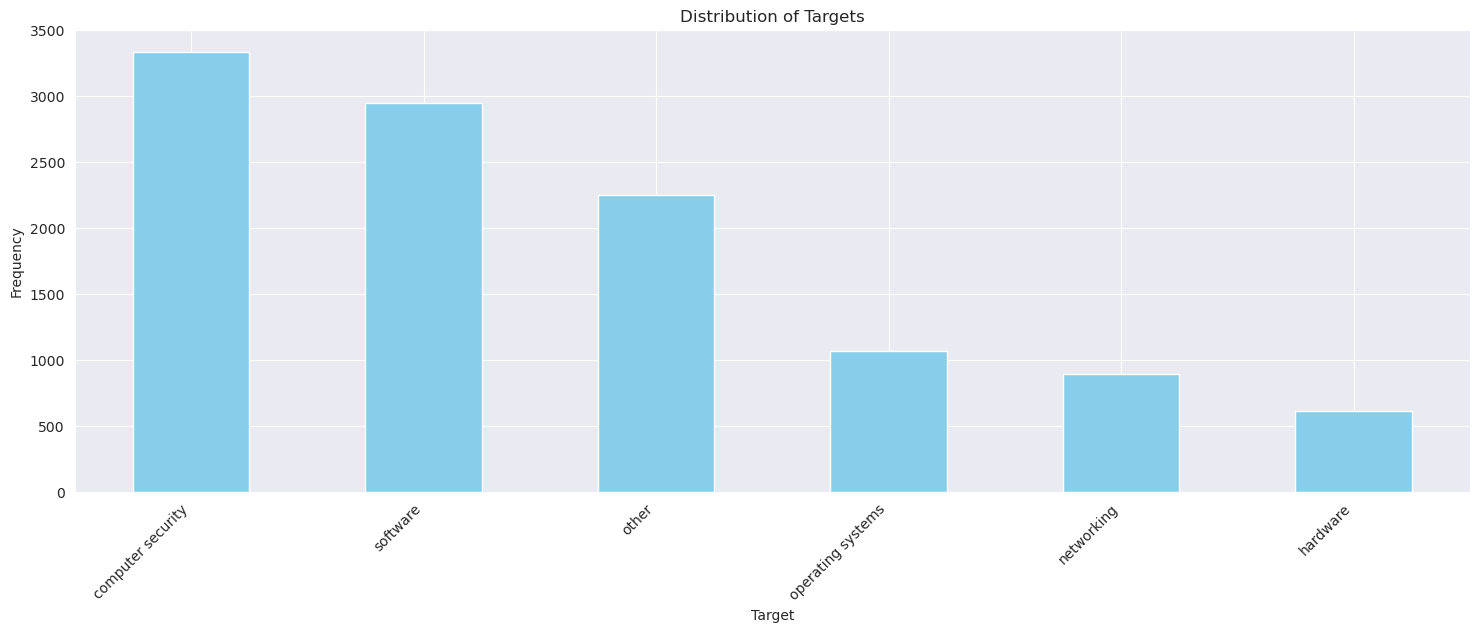

In [22]:
class_freq = Counter([item[0] for item in threat_tweets['target']])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer security',): 2798
('other',): 2255
('software', 'computer security'): 1439
('software',): 803
('hardware',): 611
('computer security', 'hardware'): 540
('software', 'hardware'): 441
('operating systems', 'software'): 392
('software', 'computer security', 'hardware'): 269
('networking',): 208
('operating systems', 'software', 'computer security'): 196
('networking', 'software', 'computer security'): 179
('networking', 'software'): 179
('networking', 'computer security'): 148
('operating systems',): 143
('operating systems', 'computer security'): 132
('operating systems', 'software', 'hardware'): 77
('networking', 'computer security', 'hardware'): 70
('networking', 'hardware'): 68
('operating systems', 'hardware'): 66
('networking', 'software', 'hardware'): 38
('operating systems', 'computer security', 'hardware'): 36
('operating systems', 'computer security', 'networking'): 10
('operating systems', 'software', 'networking'): 9
('operating systems', 'networ

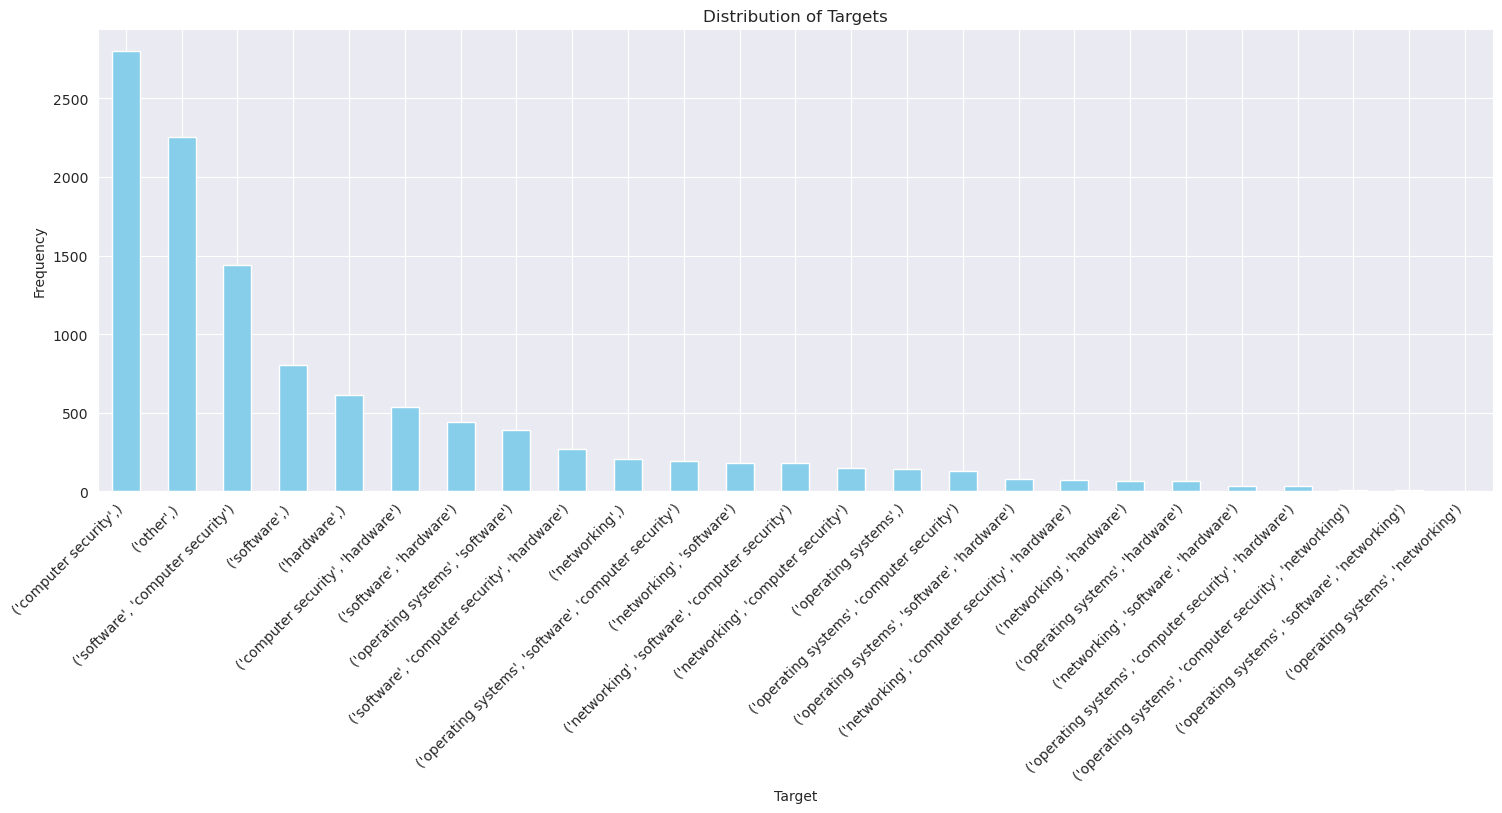

In [23]:
target_freq = Counter(tuple(item) for item in threat_tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [24]:
# Multi-Label Analysis
multi_label_counts = threat_tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 4294


In [25]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(threat_tweets['target'], threat_tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'networking':
https            1020
2018              313
cve               293
vulnerability     275
remote            151
ddos              119
prestashop        112
attack             95
allows             90
access             82
dtype: int64
Top 10 words for target 'other':
https          1961
0day            961
ransomware      751
2018            609
00              513
lt              471
alarm           464
calibration     464
cb_xlabor       464
dauertest       464
dtype: int64
Top 10 words for target 'hardware':
https            2540
vulnerability     884
android           336
cve               323
2018              320
ransomware        290
phones            259
major             256
ddos              254
manufacturers     252
dtype: int64
Top 10 words for target 'operating systems':
https            1132
vulnerability     488
2018              302
cve               295
overflow          270
buffer            258
windows           211
microsoft      

## 5. Feature Engineering

In [26]:
# BR, CLR, CC, CDN, MBR, LP, PSt
X_train_val, X_test, y_train_val, y_test, y_train_val_lp, y_test_lp = train_test_split(
    X, y, y_lp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_lp
)

X_train_val.shape, y_train_val.shape, y_train_val_lp.shape, X_test.shape, y_test.shape, y_test_lp.shape

((8889, 300), (8889, 6), (8889,), (2223, 300), (2223, 6), (2223,))

Perform pruning and subsampling of the dataset to remove infrequent targets

In [27]:
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=X_train_val,
    y=y_train_val,
    pruning_threshold=np.median(np.array(list(target_freq.values()))) * .25,
    max_sub_samples=round(np.median(np.array(list(target_freq.values()))) * .25)
)

## 6. Model Training

In [28]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_lp, y_val_lp = train_test_split(
    X_train_val, y_train_val, y_train_val_lp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_train_val_lp
)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_train_lp.shape, y_val_lp.shape

((7111, 300), (7111, 6), (1778, 300), (1778, 6), (7111,), (1778,))

In [29]:
# PSt
X_train_pst, X_val_pst, y_train_pst, y_val_pst = train_test_split(
    X_pst, y_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_pst
)

X_train_pst.shape, y_train_pst.shape, X_val_pst.shape, y_val_pst.shape

((9790, 300), (9790,), (2448, 300), (2448,))

### 4.1. Binary Problems


#### 4.1.1. BR (Binary Relevance)


In [30]:
if RETRAIN:
    for k in tqdm(BASE_CLASSIFIERS.keys()):
        br[k] = OneVsRestClassifier(estimator=BASE_CLASSIFIERS[k]).fit(X=X_train, y=y_train)

#### 4.1.2. CLR (Calibrated Label Ranking)


In [31]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = CalibratedLabelRankClassifier(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        clr[k] = model.fit(
            x=X_train,
            y=[list(mlb.classes_[np.where(row == 1)[0]]) for row in y_train]
        )

#### 4.1.3. CC (Classifier Chains)


In [32]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ChainOfClassifiers(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        cc[k] = model.fit(
            x=X_train,
            y=y_train
        )

### 4.2. Multi-class Problems



#### 4.2.1. LP (Label Powerset)


In [33]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_lp,
            random_state=RANDOM_STATE
        )

        lp[k] = model.fit(
            x=X_train,
            y=y_train_lp
        )

#### 4.2.2. PSt (Pruned Sets)


In [34]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_pst,
            random_state=RANDOM_STATE
        )

        pst[k] = model.fit(
            x=X_train_pst,
            y=y_train_pst
        )

### 4.3. Ensembles


#### 4.3.1. CDN (Conditional Dependency Network)


In [35]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ConditionalDependencyNetwork(
            classifier=v,
            num_iterations=100,
            burn_in=10
        )

        cdn[k] = model.fit(
            x=X_train,
            y=y_train
        )

#### 4.3.2. MBR (Meta-Binary Relevance)


In [36]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = MetaBinaryRelevance(
            classifier=v,
            use_cross_val=True,
            n_splits=5
        )

        mbr[k] = model.fit(
            x=X_train,
            y=y_train
        )

## 7. Model Evaluation

In [37]:
performances = {}

### 7.1. Binary Problems



#### 7.1.1. BR (Binary Relevance)


In [38]:
performances['BR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=br,
    classes=mlb.classes_
)

In [39]:
y_val_hat = performances['BR']['Model'].predict(X_val)
print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.87      0.87      0.87       930
         hardware       0.89      0.54      0.67       355
       networking       0.88      0.53      0.66       146
operating systems       0.97      0.67      0.79       170
            other       0.85      0.63      0.73       361
         software       0.87      0.79      0.83       643

        micro avg       0.87      0.74      0.80      2605
        macro avg       0.89      0.67      0.76      2605
     weighted avg       0.88      0.74      0.80      2605
      samples avg       0.76      0.74      0.74      2605

Accuracy:	0.6361
AUC:	0.8143


#### 7.1.2. CLR (Calibrated Label Ranking)


In [40]:
performances['CLR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=clr,
    classes=mlb.classes_
)

In [41]:
y_val_hat = performances['CLR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.87      0.86      0.87       930
         hardware       0.85      0.60      0.70       355
       networking       0.81      0.59      0.68       146
operating systems       0.94      0.74      0.83       170
            other       0.81      0.70      0.75       361
         software       0.86      0.81      0.83       643

        micro avg       0.86      0.77      0.81      2605
        macro avg       0.86      0.71      0.78      2605
     weighted avg       0.86      0.77      0.81      2605
      samples avg       0.77      0.76      0.76      2605

Accuracy:	0.6547
AUC:	0.8320


#### 7.1.3. CC (Classifier Chains)


In [42]:
performances['CC'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cc,
    classes=mlb.classes_
)

In [43]:
y_val_hat = performances['CC']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.86      0.87      0.86       930
         hardware       0.84      0.57      0.68       355
       networking       0.80      0.59      0.68       146
operating systems       0.94      0.73      0.82       170
            other       0.67      0.83      0.74       361
         software       0.86      0.81      0.83       643

        micro avg       0.82      0.78      0.80      2605
        macro avg       0.83      0.73      0.77      2605
     weighted avg       0.83      0.78      0.80      2605
      samples avg       0.81      0.79      0.79      2605

Accuracy:	0.6924
AUC:	0.8345


### 7.2. Multi-class Problems




#### 7.2.1. LP (Label Powerset)



In [44]:
performances['LP'] = assess_models(
    x=X_val,
    y=np.array([list(label_map_lp[yp]) for yp in y_val_lp]),
    technique=lp,
    classes=mlb.classes_
)

In [45]:
y_val_hat = performances['LP']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.84      0.90      0.87       930
         hardware       0.90      0.54      0.68       355
       networking       0.88      0.58      0.69       146
operating systems       0.95      0.68      0.79       170
            other       0.69      0.82      0.75       361
         software       0.85      0.76      0.81       643

        micro avg       0.83      0.77      0.80      2605
        macro avg       0.85      0.71      0.76      2605
     weighted avg       0.84      0.77      0.80      2605
      samples avg       0.81      0.78      0.79      2605

Accuracy:	0.6935
AUC:	0.8243


#### 7.2.2. PSt (Pruned Sets)


In [46]:
performances['PST'] = assess_models(
    x=X_val_pst,
    y=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    technique=pst,
    classes=mlb.classes_
)

In [47]:
y_val_hat = performances['PST']['Model'].predict(X_val_pst)

print(classification_report(
    y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.86      0.89      0.87      1095
         hardware       0.74      0.77      0.75       619
       networking       0.60      0.83      0.70       334
operating systems       0.86      0.44      0.58       343
            other       0.85      0.84      0.85       361
         software       0.92      0.76      0.83       799

        micro avg       0.81      0.79      0.80      3551
        macro avg       0.80      0.75      0.76      3551
     weighted avg       0.83      0.79      0.80      3551
      samples avg       0.80      0.78      0.78      3551

Accuracy:	0.6708
AUC:	0.8467


### 7.3. Ensembles


#### 7.3.1. CDN (Conditional Dependency Network)


In [48]:
performances['CDN'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cdn,
    classes=mlb.classes_
)

In [49]:
y_val_hat = performances['CDN']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.78      0.79      0.79       930
         hardware       0.75      0.54      0.63       355
       networking       0.76      0.48      0.59       146
operating systems       0.91      0.65      0.76       170
            other       0.47      0.60      0.52       361
         software       0.79      0.74      0.76       643

        micro avg       0.73      0.69      0.71      2605
        macro avg       0.74      0.63      0.68      2605
     weighted avg       0.74      0.69      0.71      2605
      samples avg       0.69      0.67      0.67      2605

Accuracy:	0.5619
AUC:	0.7673


#### 7.3.2. MBR (Meta-Binary Relevance)


In [50]:
performances['MBR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=mbr,
    classes=mlb.classes_
)

In [51]:
y_val_hat = performances['MBR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                   precision    recall  f1-score   support

computer security       0.87      0.87      0.87       930
         hardware       0.86      0.56      0.68       355
       networking       0.82      0.59      0.69       146
operating systems       0.93      0.73      0.82       170
            other       0.81      0.71      0.75       361
         software       0.87      0.79      0.83       643

        micro avg       0.86      0.76      0.81      2605
        macro avg       0.86      0.71      0.77      2605
     weighted avg       0.86      0.76      0.80      2605
      samples avg       0.78      0.76      0.76      2605

Accuracy:	0.6603
AUC:	0.8291


## 8. Summary


In [52]:
performances = pd.DataFrame(performances).T
performances

,Accuracy,Classifier,Model,Precision example-based,Recall example-based,F1 example-based,Hamming loss,Micro precision,Micro recall,Micro F1,Macro precision,Macro recall,Macro F1,Coverage,Classification
BR,0.636108,xgb,OneVsRestClassifier(estimator=XGBClassifier(ba...,0.762233,0.736689,0.737509,0.089426,0.873699,0.740883,0.801828,0.888554,0.673328,0.759132,2.92351,precision recall f1-sco...
CLR,0.654668,xgb,CalibratedLabelRankClassifier(classes=array(['...,0.772638,0.762092,0.756125,0.088114,0.857757,0.766219,0.809408,0.856862,0.714567,0.776035,2.802025,precision recall f1-sco...
CC,0.692351,xgb,ChainOfClassifiers(classes=array(['computer se...,0.806899,0.788151,0.787045,0.093738,0.824767,0.782342,0.802994,0.82688,0.732239,0.769206,2.65973,precision recall f1-sco...
LP,0.693476,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.810086,0.782902,0.785883,0.094488,0.828466,0.773129,0.799841,0.851387,0.71253,0.764076,2.676603,precision recall f1-sco...
PST,0.670752,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.801266,0.782339,0.780161,0.095792,0.812172,0.785413,0.798568,0.804677,0.754912,0.76439,2.737745,precision recall f1-sco...
CDN,0.573116,xgb,ConditionalDependencyNetwork(classifier=XGBCla...,0.701209,0.685789,0.681678,0.136389,0.732042,0.696353,0.713752,0.744735,0.639183,0.680349,3.177728,precision recall f1-sco...
MBR,0.660292,xgb,MetaBinaryRelevance(classifier=XGBClassifier(b...,0.779762,0.761061,0.759264,0.088583,0.860556,0.760461,0.807418,0.85932,0.707424,0.771934,2.8009,precision recall f1-sco...


In [53]:
if OVERWRITE:
    joblib.dump(br, BR_PKL, compress=9)
    joblib.dump(clr, CLR_PKL, compress=9)
    joblib.dump(cc, CC_PKL, compress=9)
    joblib.dump(lp, LP_PKL, compress=9)
    joblib.dump(pst, PST_PKL, compress=9)
    joblib.dump(cdn, CDN_PKL, compress=9)
    joblib.dump(mbr, MBR_PKL, compress=9)